# Ch. 6

In [1]:
# minimal imports
import pandas as pd
import numpy as np
from plotnine import *
import plotnine as p9

# for graphical enhancement
from mizani.formatters import date_format, percent_format, dollar_format, comma_format

# In most cases, you may not import them.
# you may need them If only you are adhere to color determination...
from matplotlib.pylab import cm
from matplotlib.colors import rgb2hex
from pysocviz.properties import colors

# Needed by smoothing and modeling
# You need to install scikit-misc package
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm

# dataset packages
from gapminder import gapminder

p9.options.figure_size = (5.4, 4.8)
theme_set(theme_minimal(base_family='Noto Sans CJK JP'))

## Fig. 6.1


NOTE: Currently (v0.8) `plotnine.geom.geom_quantile` doesn't support addtive quantile regression model like RQSS. So I instedly use linear quantile regression algorithm.

/usr/local/lib/python3.8/dist-packages/plotnine/stats/smoothers.py:153: PlotnineWarning: Confidence intervals are not yet implementedfor RLM smoothing.
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.


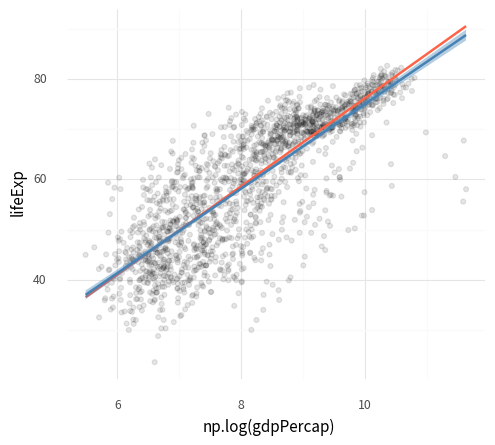

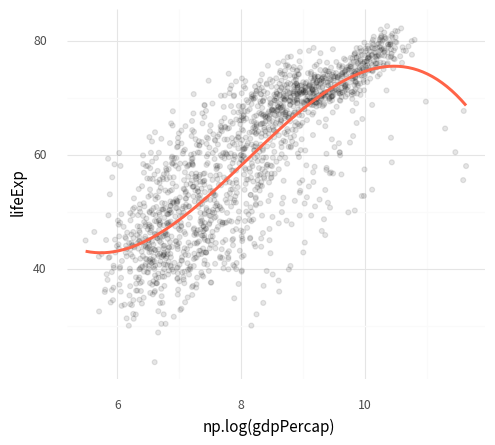

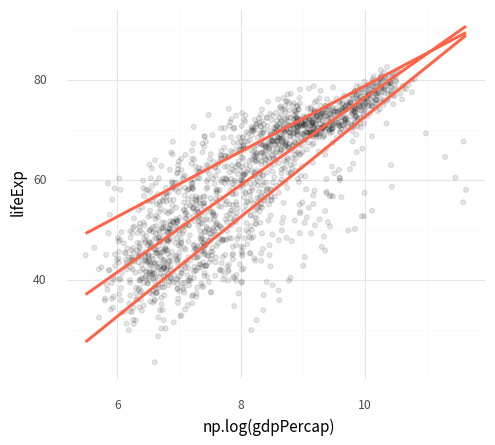

In [2]:
p = ggplot(gapminder, aes(x='np.log(gdpPercap)', y='lifeExp'))

(
  p + geom_point(alpha=0.1) + geom_smooth(
    color="tomato", fill="tomato", method='rlm'
  ) + geom_smooth(color="steelblue", fill="steelblue", method="lm")
).draw();

(
  p + geom_point(alpha=0.1) + geom_smooth(
    color="tomato", method="lm", size=1.2, formula='y ~ bs(x, 3)',
    se=False
  )
).draw();
(
  p + geom_point(alpha=0.1) + geom_quantile(
    color="tomato", size=1.2, quantiles=[0.20, 0.5, 0.85])
).draw();

## Fig. 6.2

NOTE: As I mentioned about Fig. 5.26, I think the original code is unreliable. I suggest to use a named vector with `ggplot2::scale_color_manual`, while to use a dictionary with `plotnine.sacle_color_manual`

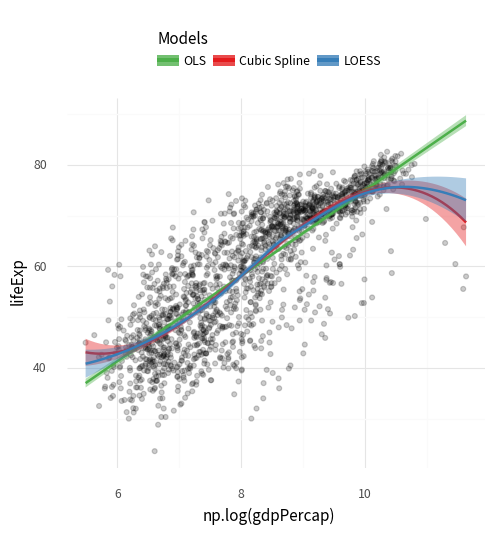

<ggplot: (8731463607303)>

In [3]:
model_colors = cm.get_cmap('Set1')
model_colors = {
  ['Cubic Spline', 'LOESS', 'OLS'][i]: rgb2hex(model_colors(i)
    ) for i in range(model_colors.N) if i < 3
}

p0 = ggplot(gapminder, aes(x='np.log(gdpPercap)', y='lifeExp'))
p1 = p0 + geom_point(alpha=0.2) + geom_smooth(
  aes(color='"OLS"', fill='"OLS"'),
  method='lm',
) + geom_smooth(
  aes(color='"Cubic Spline"', fill='"Cubic Spline"'),
  method='lm', formula='y ~ bs(x, df = 3)',
) + geom_smooth(aes(color='"LOESS"', fill='"LOESS"'), method='loess')

# TODO: legend order
p1 + scale_color_manual(name="Models", values=model_colors
) + scale_fill_manual(name="Models", values=model_colors
) + theme(legend_position="top")

## Fig. 6.4

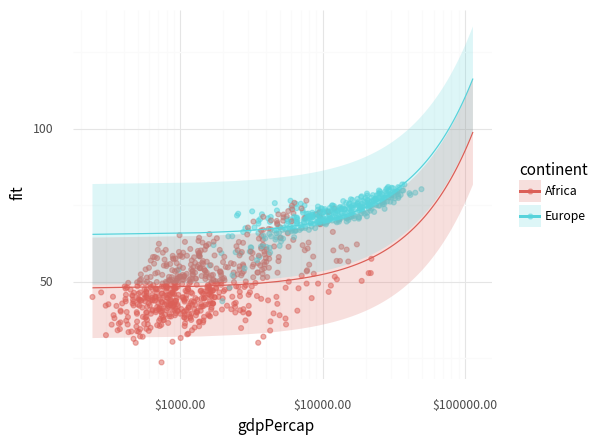

<ggplot: (8731461259755)>

In [4]:
out = ols('lifeExp ~ gdpPercap + pop + continent', data=gapminder).fit()
out.summary()
min_gdp, max_gdp = gapminder['gdpPercap'].min(), gapminder['gdpPercap'].max()
med_pop = gapminder['pop'].median()
pred_df = pd.DataFrame(
  np.array(
    [(gdp, con) for gdp in np.linspace(
      min_gdp, max_gdp, 100
    ) for con in gapminder['continent'].unique()]
  ),
  columns=['gdpPercap', 'continent']
).assign(pop=med_pop, gdpPercap=lambda d: d['gdpPercap'].astype(float))
pred_out = out.get_prediction(pred_df).summary_frame(alpha=.05)  # .predict() cannot display the c.i.
pred_out = pred_out.rename(
  columns={'mean': 'fit', 'obs_ci_lower': 'lwr', 'obs_ci_upper': 'upr'}
)[['fit', 'lwr', 'upr']]
pred_out.head()
pred_df = pd.concat((pred_df, pred_out), axis=1)

p = ggplot(
  pred_df.loc[lambda d: d['continent'].isin(['Europe', 'Africa'])],
  aes(x='gdpPercap', y='fit', ymin='lwr', ymax='upr', color='continent',
      fill='continent', group='continent')
)

p + geom_point(
  aes(x='gdpPercap', y='lifeExp', color='continent'),
  data=gapminder.loc[lambda d: d['continent'].isin(['Europe', 'Africa'])],
  alpha = 0.5, inherit_aes = False
) + geom_line() + geom_ribbon(
  alpha=0.2, color=None
) + scale_x_log10(labels=dollar_format())

## Fig. 6.5

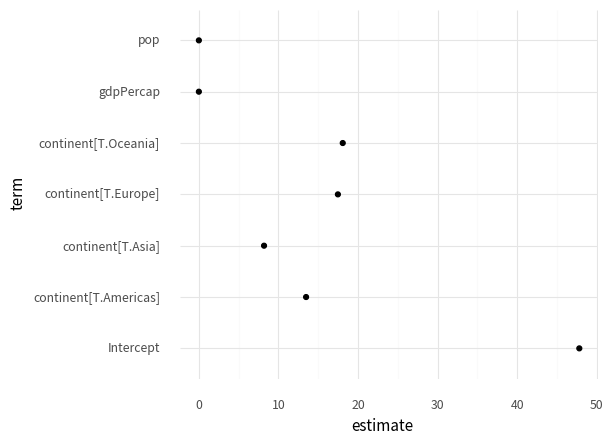

<ggplot: (8731463549585)>

In [5]:
out_comp = pd.DataFrame(
  {
    'estimate': out.params,
    'std_error': out.bse,
    'statistic': out.tvalues,
    'p_value': out.pvalues
  }
).reset_index().rename(columns={'index': 'term'})

out_comp.round(2)

p = ggplot(out_comp, aes(x='term', y='estimate'))
p + geom_point() + coord_flip()

## Fig. 6.6

<ipython-input-6-03fe7b38905f>:12: FutureWarning: The default value of regex will change from True to False in a future version.


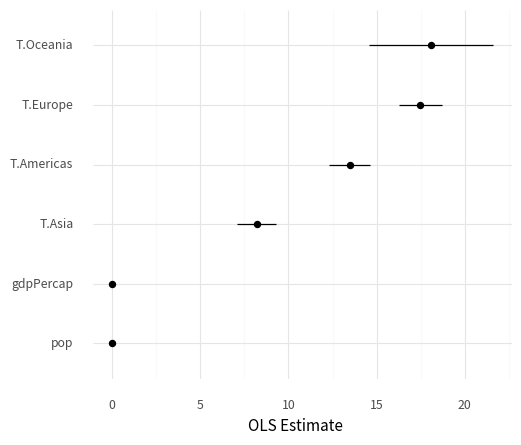

<ggplot: (8731461198327)>

In [6]:
out_conf = pd.concat(
  (
    out_comp,
    out.conf_int().reset_index(drop=True)
  ),
  axis=1
).rename(
    columns={0: 'conf_low', 1: 'conf_high'}
)
out_conf = out_conf.loc[lambda d: ~d['term'].isin(['Intercept'])]
out_conf = out_conf.assign(
  nicelabs=lambda d: d['term'].str.replace("^continent\[(.+?)\]$", r"\1")
)
p = ggplot(
  out_conf,
  aes(
    x='reorder(nicelabs, estimate)',
    y='estimate',
    ymin='conf_low',
    ymax='conf_high'
  )
)
p + geom_pointrange() + coord_flip() + labs(x="", y="OLS Estimate")

## Fig. 6.7

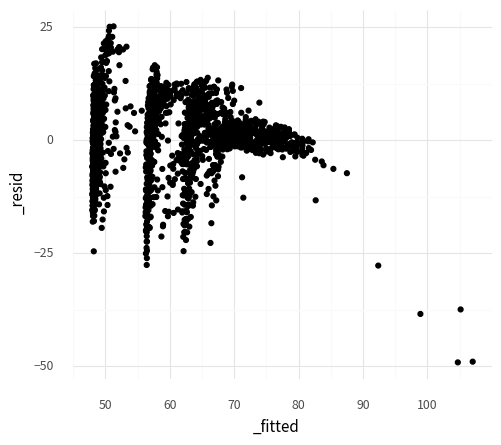

<ggplot: (8731461259593)>

In [7]:
out_aug = pd.concat([
  gapminder.assign(
    _fitted=out.fittedvalues,
    # _se_fit=None,  # not available for linear regression
    _resid=out.resid
  ),
  out.get_influence().summary_frame().rename(
    columns={
      'hat_diag': '_hat',
      'cooks_d': '_cooksd',
      'dffits': '_sigma', # TODO: Really?
      'standard_resid': '_std_resid' 
      }
    )[['_hat', '_cooksd', '_sigma', '_std_resid']]
  ],
  axis=1
)
p = ggplot(out_aug, aes(x='_fitted', y='_resid'))
p + geom_point()

## Fig. 6.8

In [8]:
# lung の用意がめんどくさいので省略


## Fig. 6.9

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in 

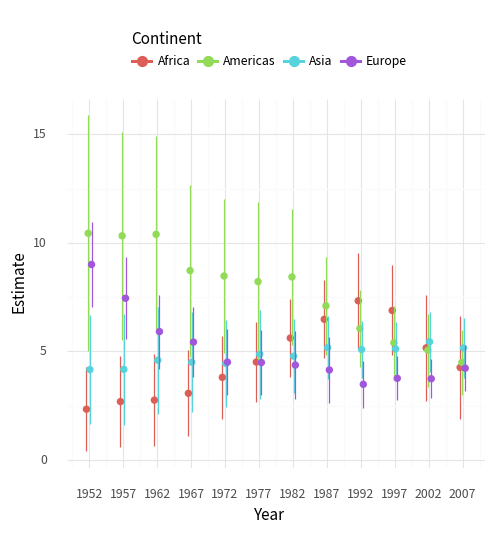

<ggplot: (8731463600595)>

In [9]:
def tidy_ols(OLSResult):
  return pd.DataFrame(
    {
      'estimate': OLSResult.params,
      'std_error': OLSResult.bse,
      'statistic': OLSResult.tvalues,
      'p_value': OLSResult.pvalues
    }
  ).reset_index().rename(columns={'index': 'term'})

out_tidy = gapminder.groupby(['continent', 'year']).apply(
  lambda x: tidy_ols(ols('lifeExp ~ np.log(gdpPercap)', data=x).fit())
).reset_index().drop(['level_2'], 1
).loc[
  lambda d: (
    ~d['term'].isin(['Intercept'])
    ) & (
      ~d['continent'].isin(['Oceania']
    ))  # 回帰の前に消したほうがいいような...
]

p = ggplot(
  out_tidy,
  aes(
    x='year',
    y='estimate',
    ymin='estimate - 2 * std_error',
    ymax='estimate + 2 * std_error',
    group='continent',
    color='continent'
  )
)
p + geom_pointrange(
  position=position_dodge(width=1)
) + scale_x_continuous(
  breaks=gapminder['year'].unique()
) + theme(legend_position='top') + labs(
  x='Year', y='Estimate', color='Continent'
)

## Fig. 6.10

In [10]:
# TODO: how to calculate marginal effects easily
out_bo = glm(
  'obama ~ C(polviews, Treatment(reference="Moderate")) + sex*race',
  data=gss_sm, family=sm.families.Binomial()).fit()
out_bo.summary()

# p = ggplot(bo_gg, aes(x='reorder(factor, AME)', y='AME', ymin='lower', ymax='upper'))
# p + geom_hline(yintercept=0, color=colors["gray80"]) + geom_pointrange(
)#  + coord_flip() + labs(x=None, y="Average Marginal Effect") 

SyntaxError: unmatched ')' (<ipython-input-10-d92c1256ab11>, line 9)

## Fig. 6.11

In [ ]:
# TODO

## Fig. 6.12

In [ ]:
# TODO

## Fig. 6.13

In [ ]:
# TODO
# draw();

## Fig. 6.14

In [ ]:
# TODO